In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score,roc_auc_score,recall_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix

C:\Users\umairansari\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [13]:
test=pd.read_csv("cleaned_data_test_feature_engineered.csv")


In [2]:
#loading the data
data_train_smote=pd.read_csv("full_train_after_smote.csv")
data_test_smote=pd.read_csv("cleaned_data_test_feature_engineered.csv")


#dropping the feature engineered data from test

data_test_smote=data_test_smote.drop(["YEAR","INCIDENT_ID","MONTH","DAY","DATE"],axis=1)
data_train_smote=data_train_smote.drop(["INCIDENT_ID"],axis=1)

print(data_train_smote.shape,data_test_smote.shape)


#splitting into train and validation
train,val=train_test_split(data_train_smote,test_size=.20,random_state=42)
train.shape,val.shape


#splitting into x and y
Xfull=data_train_smote.drop(["MULTIPLE_OFFENSE"],axis=1)
yfull=data_train_smote["MULTIPLE_OFFENSE"]
print(Xfull.shape,yfull.shape)


Xtrain=train.drop(["MULTIPLE_OFFENSE"],axis=1)
ytrain=train["MULTIPLE_OFFENSE"]
print(Xtrain.shape,ytrain.shape)

Xval=val.drop(["MULTIPLE_OFFENSE"],axis=1)
yval=val["MULTIPLE_OFFENSE"]
print(Xval.shape,yval.shape)


(45572, 16) (15903, 15)
(45572, 15) (45572,)
(36457, 15) (36457,)
(9115, 15) (9115,)


In [3]:
lrc = LogisticRegression(class_weight="balanced")
rfc=RandomForestClassifier(class_weight="balanced")
adbc=AdaBoostClassifier()
bgc=BaggingClassifier()
gnb = GaussianNB()
knn=KNeighborsClassifier()
dtc = DecisionTreeClassifier()
bgcl_lrc = BaggingClassifier(base_estimator=lrc, random_state=42)
ab_rfc = AdaBoostClassifier(base_estimator=rfc,random_state=42)
ab_dtc = AdaBoostClassifier(base_estimator=dtc,random_state=42)
ab_nbc=  AdaBoostClassifier(base_estimator=gnb,random_state=42)
ab_lrc=  AdaBoostClassifier(base_estimator=lrc,random_state=42)
gbc=GradientBoostingClassifier()
ab_gbc=  AdaBoostClassifier(base_estimator=gbc,random_state=42)
xgbc=XGBClassifier()
ab_xgbc=  AdaBoostClassifier(base_estimator=xgbc,random_state=42)
lgbc=LGBMClassifier(class_weight="balanced")

In [5]:
# %%time
# #checking crossval for the data 
# i=1
# kf = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
# for train_index,test_index in kf.split(Xfull,yfull):
#     print('\n{} of kfold {}'.format(i,kf.n_splits))
#     xtr,xvl = Xfull.loc[train_index],Xfull.loc[test_index]
#     ytr,yvl = yfull[train_index],yfull[test_index]
#     model = AdaBoostClassifier(base_estimator=gbc,random_state=42)
#     model.fit(xtr, ytr)
#     #print (model.best_params_)
#     pred=model.predict(xvl)
#     print('roc_auc_score',roc_auc_score(yvl,pred))
#     i+=1


1 of kfold 10
roc_auc_score 0.9993418165862221

2 of kfold 10
roc_auc_score 0.999341816586222

3 of kfold 10
roc_auc_score 0.9995612110574814

4 of kfold 10
roc_auc_score 0.9986834405521884

5 of kfold 10
roc_auc_score 0.9995611147473534

6 of kfold 10
roc_auc_score 0.9993417202760942

7 of kfold 10
roc_auc_score 0.9993416239659663

8 of kfold 10
roc_auc_score 0.9995612110574814

9 of kfold 10
roc_auc_score 0.9993415276558384

10 of kfold 10
roc_auc_score 0.9989027387133198
Wall time: 2h 49min 53s


In [4]:


models=[lrc,rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,ab_rfc,ab_dtc,ab_nbc,ab_lrc,gbc,ab_gbc,xgbc,ab_xgbc,lgbc]
sctr,scte,auc,ps,rs=[],[],[],[],[]
def ensemble_for_train_val(X_train,X_test, y_train, y_test):
    for model in models:
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
            y_test_pred_new=model.predict_proba(X_test)
            y_test_pred_new=y_test_pred_new[:,1]
            train_score=model.score(X_train,y_train)
            test_score=model.score(X_test,y_test)
            p_score=metrics.precision_score(y_test,y_test_pred)
            r_score=metrics.recall_score(y_test,y_test_pred)
            
            ac=metrics.roc_auc_score(y_test,y_test_pred_new)
            
            sctr.append(train_score)
            scte.append(test_score)
            ps.append(p_score)
            rs.append(r_score)
            auc.append(ac)
    return sctr,scte,auc,ps,rs


#checking the performance on train and validation
ensemble_for_train_val(Xtrain,Xval, ytrain, yval)
# 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'
ensemble=pd.DataFrame({'names':['Logistic Regression','Random Forest','Ada boost','Bagging',
                                'Naive-Bayes','KNN','Decistion Tree',
                                'bagged LR',"adaboost rf","adaboost dtc","adaboost naive bayes",
                                "adaboost logistic regression","gradient boosting trees"
                                ,"adaboost gbc","xgboost","adaboost xgbc","ligh gbm"],
                       'auc_score':auc,'training':sctr,'testing':scte,'precision':ps,'recall':rs})
ensemble=ensemble.sort_values(by='auc_score',ascending=False).reset_index(drop=True)
ensemble

,names,auc_score,training,testing,precision,recall
0,adaboost gbc,0.999977,1.000000,0.999232,0.998904,0.999561
1,ligh gbm,0.999955,1.000000,0.998464,0.998465,0.998465
2,adaboost rf,0.999774,1.000000,0.995502,0.997796,0.993200
3,Random Forest,0.999742,1.000000,0.995283,0.997357,0.993200
4,xgboost,0.999734,0.995392,0.994076,0.994946,0.993200
5,gradient boosting trees,0.999721,0.995145,0.994185,0.994947,0.993420
6,Ada boost,0.999547,0.993609,0.992649,0.995806,0.989471
7,Bagging,0.998975,0.999643,0.996489,0.997145,0.995832
8,adaboost dtc,0.995721,1.000000,0.995721,0.995397,0.996052
9,Decistion Tree,0.995721,1.000000,0.995721,0.995180,0.996271


In [5]:
ensemble=ensemble.sort_values(by='recall',ascending=False).reset_index(drop=True)
ensemble

,names,auc_score,training,testing,precision,recall
0,adaboost gbc,0.999977,1.000000,0.999232,0.998904,0.999561
1,ligh gbm,0.999955,1.000000,0.998464,0.998465,0.998465
2,Decistion Tree,0.995721,1.000000,0.995721,0.995180,0.996271
3,adaboost dtc,0.995721,1.000000,0.995721,0.995397,0.996052
4,Bagging,0.998975,0.999643,0.996489,0.997145,0.995832
5,gradient boosting trees,0.999721,0.995145,0.994185,0.994947,0.993420
6,xgboost,0.999734,0.995392,0.994076,0.994946,0.993200
7,Random Forest,0.999742,1.000000,0.995283,0.997357,0.993200
8,adaboost rf,0.999774,1.000000,0.995502,0.997796,0.993200
9,Ada boost,0.999547,0.993609,0.992649,0.995806,0.989471


In [9]:

def cross_val(fullx,fully,kfold,models,model_names,i=1):
    dictionary_cv={}
    cross_val_score_auc=[]
    for model in models:
        
        for train_index,test_index in kfold.split(fullx,fully):
            p=1
            print('\n{} of kfold {}'.format(p,kf.n_splits))
            xtr,xvl = Xfull.loc[train_index],Xfull.loc[test_index]
            ytr,yvl = yfull[train_index],yfull[test_index]
            model.fit(xtr, ytr)
            pred=model.predict(xvl)
            print('roc_auc_score',roc_auc_score(yvl,pred))
            cross_val_score_auc.append(roc_auc_score(yvl,pred))
            p+=1
        temp_name=model_names[i-1]
        dictionary_cv[temp_name]=cross_val_score_auc
        cross_val_score_auc=[]
        p=1
        i+=1
    result_cross_validation=pd.DataFrame(list(dictionary_cv.items()))
    return result_cross_validation

kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

# models_to_cross_validate=[lrc,rfc]
# # models=
# model_names=['Logistic Regression','Random Forest',]

models_to_cross_validate=[lrc,rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,
                          ab_rfc,ab_dtc,ab_nbc,ab_lrc,gbc,ab_gbc,xgbc,ab_xgbc,lgbc]
# models=
model_names=['Logistic Regression','Random Forest','Ada boost','Bagging',
                                'Naive-Bayes','KNN','Decistion Tree',
                                'bagged LR',"adaboost rf","adaboost dtc","adaboost naive bayes",
                                "adaboost logistic regression","gradient boosting trees",
             "adaboost gbc","xgboost","adaboost xgbc","light gbm"]

result_cv=cross_val(fullx=Xfull,fully=yfull,kfold=kf,
                    models=models_to_cross_validate,model_names=model_names)
result_cv.to_csv("cross_val_results.csv",index=False)


1 of kfold 5
roc_auc_score 0.8604509617970532

1 of kfold 5
roc_auc_score 0.8582537914031838

1 of kfold 5
roc_auc_score 0.8579109062980032

1 of kfold 5
roc_auc_score 0.8655913978494624

1 of kfold 5
roc_auc_score 0.8630678077682686

1 of kfold 5
roc_auc_score 0.994953156849089

1 of kfold 5
roc_auc_score 0.9958312402513412

1 of kfold 5
roc_auc_score 0.9967083607636603

1 of kfold 5
roc_auc_score 0.9969278033794163

1 of kfold 5
roc_auc_score 0.9959403116085144

1 of kfold 5
roc_auc_score 0.991551988882858

1 of kfold 5
roc_auc_score 0.9931980973680077

1 of kfold 5
roc_auc_score 0.9928681149879307

1 of kfold 5
roc_auc_score 0.9947333772218565

1 of kfold 5
roc_auc_score 0.9938556067588326

1 of kfold 5
roc_auc_score 0.9964891588703877

1 of kfold 5
roc_auc_score 0.9970379579877641

1 of kfold 5
roc_auc_score 0.9962694755321484

1 of kfold 5
roc_auc_score 0.9959403116085144

1 of kfold 5
roc_auc_score 0.9971472459951723

1 of kfold 5
roc_auc_score 0.6382533494367045

1 of kfold 5
r

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


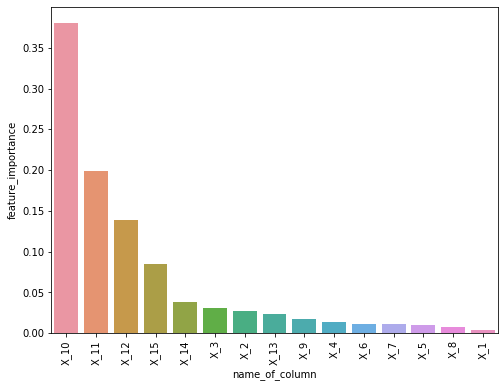

RandomForestClassifier
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


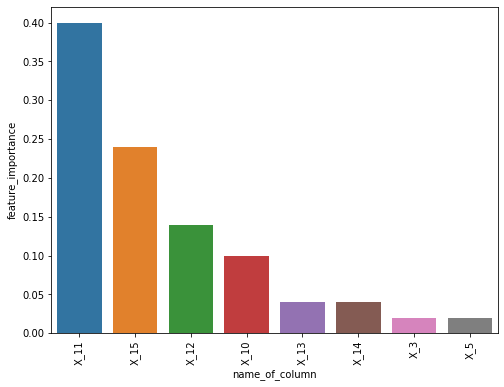

AdaBoostClassifier
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


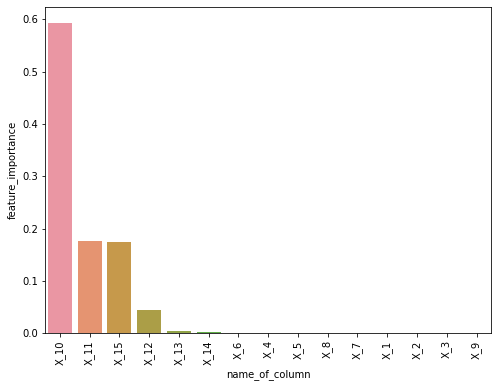

DecisionTreeClassifier
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
          

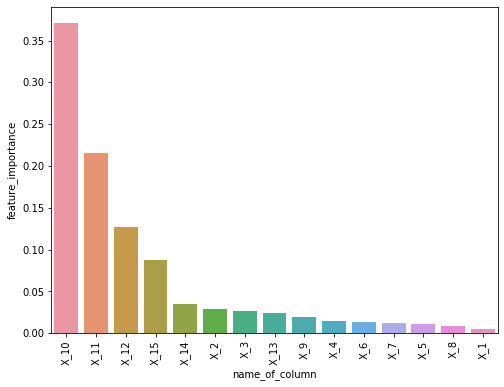

AdaBoostClassifier
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
    

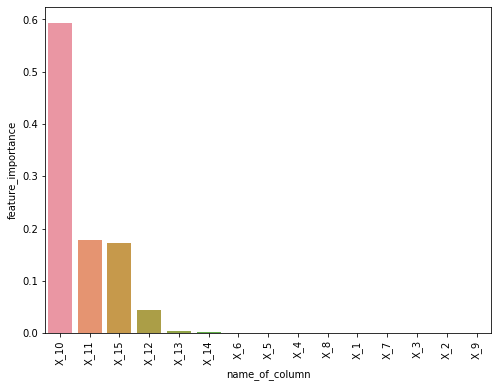

AdaBoostClassifier
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


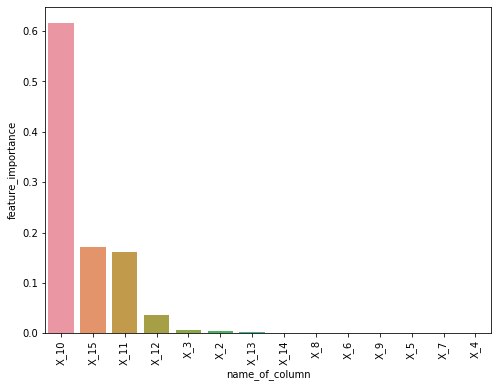

GradientBoostingClassifier
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                             criterion='friedman_mse',
                                                             init=None,
                                                             learning_rate=0.1,
                                                             loss='deviance',
                                                             max_depth=3,
                                                             max_features=None,
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                 

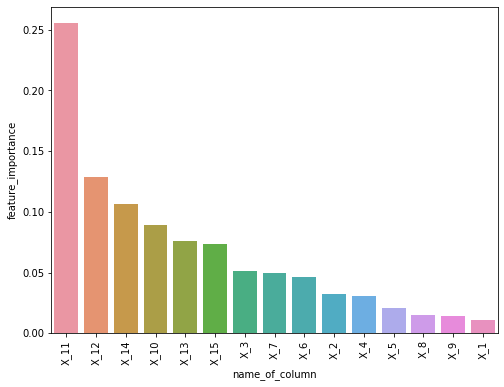

AdaBoostClassifier
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


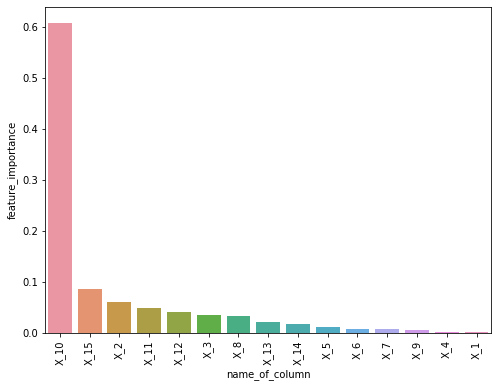

XGBClassifier
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                learning_rate=0.1,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=100,
                                                n_jobs=1, nthread=None,
                                                objective='binary:logistic',
                                                random_state=0, reg_alpha=0,
                                                reg_lambda=1,
                    

ValueError: min() arg is an empty sequence

<Figure size 576x432 with 0 Axes>

In [21]:

def plot_graph(a):
    plt.figure(figsize=(8,6))
    chart=sns.barplot(x=a["name_of_column"],y=a["feature_importance"])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    plt.show()
def feature_importance_plot_rev(dataframe,classifier,limit_of_the_importance):
    x=list(zip(dataframe.columns,classifier.feature_importances_))
    xx=pd.DataFrame(x)
    xx.columns=["name_of_column","feature_importance"]
    xx=xx.sort_values("feature_importance",ascending=False)
    xx=xx[xx["feature_importance"]>limit_of_the_importance]
    plot_graph(xx)
    return xx

models=[rfc,adbc,dtc,ab_rfc,ab_dtc,gbc,ab_gbc,xgbc,ab_xgbc]
for model in models:
    print(model)
    feature_importance_plot_rev(Xfull,model,0)
    
    print(model.__class__.__name__)
    

In [14]:
#models=[lrc,rfc,adbc,bgc,gnb,knn,dtc,bgcl_lrc,gbc,xgbc,lgbc]
# ab_rfc,ab_dtc,ab_nbc,ab_lrc,gbc,ab_gbc,xgbc,ab_xgbc
models=[lgbc]

# predictions=pd.DataFrame(data_test_smote['INCIDENT_ID'])
def pred_on_full_data(Xtrain,ytrain,Xtest,models):
    for model in models:
        print(model.__class__.__name__)
        model.fit(Xtrain, ytrain)
        y_test_pred = model.predict(Xtest)
        predictions=pd.concat([test['INCIDENT_ID'],pd.DataFrame(y_test_pred,columns=['MULTIPLE_OFFENSE'])],1)
        a="submission_feature_engineered"+model.__class__.__name__+".csv"
        predictions.to_csv(a,index=False)
        

#getting predictions on full data
pred_on_full_data(Xfull,yfull,data_test_smote,models)

LGBMClassifier
